In [1]:
from mmpose.apis import MMPoseInferencer

img_path = 'test_image.jpg'   # replace this with your own image path

# instantiate the inferencer using the model alias
inferencer = MMPoseInferencer('human')

# The MMPoseInferencer API employs a lazy inference approach,
# creating a prediction generator when given input
result_generator = inferencer(img_path, show=True)
result = next(result_generator)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
06/23 16:46:26 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
06/23 16:46:29 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a corre

c:\Python38\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
import glob #Search files
import json #JSON write
import pathlib #Path things
import os #Path things
import warnings #Modified call
from concurrent.futures import ThreadPoolExecutor #Threading
from types import MethodType #Modified call
from typing import Optional #Modified call

import numpy as np #Array operations
import imageio #EXR write
import tqdm #Progress bar
from rich.progress import track #Modified call
import mmpose #Feature extractor
from mmpose.apis import MMPoseInferencer #Feature extractor
import matplotlib.pyplot as plt

In [3]:
#Base from MMPoseInferencer.__call__
def modified_call(
        self,
        inputs: mmpose.apis.inferencers.mmpose_inferencer.InputsType,
        return_datasamples: bool = False,
        batch_size: int = 1,
        out_dir: Optional[str] = None,
        **kwargs,
    ) -> dict:
        """Call the inferencer.

        Args:
            inputs (InputsType): Inputs for the inferencer.
            return_datasamples (bool): Whether to return results as
                :obj:`BaseDataElement`. Defaults to False.
            batch_size (int): Batch size. Defaults to 1.
            out_dir (str, optional): directory to save visualization
                results and predictions. Will be overoden if vis_out_dir or
                pred_out_dir are given. Defaults to None
            **kwargs: Key words arguments passed to :meth:`preprocess`,
                :meth:`forward`, :meth:`visualize` and :meth:`postprocess`.
                Each key in kwargs should be in the corresponding set of
                ``preprocess_kwargs``, ``forward_kwargs``,
                ``visualize_kwargs`` and ``postprocess_kwargs``.

        Returns:
            dict: Inference and visualization results.
        """
        if out_dir is not None:
            if 'vis_out_dir' not in kwargs:
                kwargs['vis_out_dir'] = f'{out_dir}/visualizations'
            if 'pred_out_dir' not in kwargs:
                kwargs['pred_out_dir'] = f'{out_dir}/predictions'
        
        kwargs = {
            key: value
            for key, value in kwargs.items()
            if key in set.union(self.inferencer.preprocess_kwargs,
                                self.inferencer.forward_kwargs,
                                self.inferencer.visualize_kwargs,
                                self.inferencer.postprocess_kwargs)
        }
        (
            preprocess_kwargs,
            forward_kwargs,
            visualize_kwargs,
            postprocess_kwargs,
        ) = self._dispatch_kwargs(**kwargs)

        self.inferencer.update_model_visualizer_settings(**kwargs)

        # preprocessing
        if isinstance(inputs, str) and inputs.startswith('webcam'):
            inputs = self.inferencer._get_webcam_inputs(inputs)
            batch_size = 1
            if not visualize_kwargs.get('show', False):
                warnings.warn('The display mode is closed when using webcam '
                              'input. It will be turned on automatically.')
            visualize_kwargs['show'] = True
        else:
            inputs = self.inferencer._inputs_to_list(inputs)
        self._video_input = self.inferencer._video_input
        if self._video_input:
            self.video_info = self.inferencer.video_info

        inputs = self.preprocess(
            inputs, batch_size=batch_size, **preprocess_kwargs)

        # forward
        if 'bbox_thr' in self.inferencer.forward_kwargs:
            forward_kwargs['bbox_thr'] = preprocess_kwargs.get('bbox_thr', -1)

        preds = []

        for proc_inputs, ori_inputs in (track(inputs, description='Inference')
                                        if self.show_progress else inputs):
            preds = self.forward(proc_inputs, **forward_kwargs)

            visualization = self.visualize(ori_inputs, preds,
                                           **visualize_kwargs)
            
            results = self.postprocess(
                preds,
                visualization,
                return_datasamples=return_datasamples,
                **postprocess_kwargs)
            
            #MODIFIED START-----------------------------------
            if kwargs["draw_heatmap"] is True:
                for batch_index in range(len(preds)):
                    pred = preds[batch_index]
                
                    for person_index in range(len(pred.pred_instances)):
                        person_pred = pred.pred_instances[person_index]
                        
                        results["predictions"][batch_index][person_index]["heatmaps"] = pred._pred_heatmaps.heatmaps
            #MODIFIED END-------------------------------------
            
            yield results

        if self._video_input:
            self._finalize_video_processing(
                postprocess_kwargs.get('pred_out_dir', ''))

In [4]:
inferencer.modified_call = MethodType(modified_call, inferencer)

In [5]:
result_generator = inferencer.modified_call(img_path, draw_heatmap=True)

In [6]:
result = next(result_generator)

c:\Python38\lib\site-packages\mmpose\models\heads\coord_cls_heads\rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [13]:
heatmaps = result["predictions"][0][0]["heatmaps"]

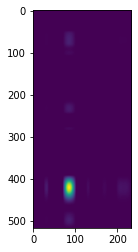

In [21]:
plt.imshow(heatmaps[16])

In [43]:
coco2unity =   {"nose": 87, #nose
               "left_eye": 80, #eye_left
               "right_eye": 81, #eye_right
               "left_ear": 85, #ear_left
               "right_ear": 86, #ear_right
               "left_shoulder": 21, #shoulder_left
               "right_shoulder": 50, #shoulder_right
               "left_elbow": 22, #elbow_left
               "right_elbow": 51, #elbow_right
               "left_wrist": 25, #wrist_left
               "right_wrist": 54, #wrist_right
               "left_hip": 88, #hip_left
               "right_hip": 89, #hip_right
               "left_knee": 2, #knee_left
               "right_knee": 10, #knee_right
               "left_ankle": 4, #ankle_left
               "right_ankle": 12, #ankle_right
            }


In [44]:
unity_labels = ['hip',
 'leg_left',
 'knee_left',
 'accessories_ankle_left',
 'ankle_left',
 'foot_left',
 'toes_left',
 'lower_leg_left',
 'upper_leg_left',
 'leg_right',
 'knee_right',
 'accessories_ankle_right',
 'ankle_right',
 'foot_right',
 'toes_right',
 'lower_leg_right',
 'upper_leg_right',
 'spine_01',
 'spine_02',
 'spine_03',
 'clavicle_left',
 'shoulder_left',
 'elbow_left',
 'accessories_wrist_left',
 'lower_arm_left',
 'wrist_left',
 'index_01_left',
 'index_02_left',
 'index_03_left',
 'index_04_left',
 'middle_01_left',
 'middle_02_left',
 'middle_03_left',
 'middle_04_left',
 'palm_left',
 'pinky_01_left',
 'pinky_02_left',
 'pinky_03_left',
 'pinky_04_left',
 'ring_01_left',
 'ring_02_left',
 'ring_0',
 'ring_03_left',
 'ring_04_left',
 'thumb_01_left',
 'thumb_02_left',
 'thumb_03_left',
 'thumb_04_left',
 'upper_arm_left',
 'clavicle_right',
 'shoulder_right',
 'elbow_right',
 'accessories_wrist_right',
 'lower_arm_right',
 'wrist_right',
 'index_01_right',
 'index_02_right',
 'index_03_right',
 'index_04_right',
 'middle_01_right',
 'middle_02_right',
 'middle_03_right',
 'middle_04_right',
 'palm_right',
 'pinky_01_right',
 'pinky_02_right',
 'pinky_03_right',
 'pinky_04_right',
 'ring_01_right',
 'ring_02_right',
 'ring_03_right',
 'ring_04_right',
 'thumb_01_right',
 'thumb_02_right',
 'thumb_03_right',
 'thumb_04_right',
 'upper_arm_right',
 'neck',
 'head',
 'accessories_radix_nose',
 'eye_left',
 'eye_right',
 'head_end',
 'jaw',
 'jaw_end',
 'ear_left',
 'ear_right',
 'nose',
 'hip_left',
 'hip_right']

In [45]:
for coco_label in coco2unity:
    unity_index = coco2unity[coco_label]
    unity_label = unity_labels[unity_index]

    print(coco_label, unity_label)

nose nose
left_eye eye_left
right_eye eye_right
left_ear ear_left
right_ear ear_right
left_shoulder shoulder_left
right_shoulder shoulder_right
left_elbow elbow_left
right_elbow elbow_right
left_wrist wrist_left
right_wrist wrist_right
left_hip hip_left
right_hip hip_right
left_knee knee_left
right_knee knee_right
left_ankle ankle_left
right_ankle ankle_right
